# Research Notebook
Lukas Lehmann (Student) <br>
Date: Jan. 20. - 26.

Comment: as the deadline was extended, the further amendments of this week were added at the end

# 1: Experience
## Describe at least one research activity you worked on this week. 

### 1: Experience
I have created a draft.py document, as well as a class BH in this document. This class contains the following functions written by me:
- The effective Potential $V_\text{eff} (r)$
- An derivative $\frac{d \varphi}{d r}(r)$ as well as the solution $\varphi (r)$ 
- A system of differential equations to get the time dependend movment of a particle. 

I have also implemented the draft file in my research file.

## Motivation:


In our research we want to investigate the predictions of different metrics for the behaviour of objects around black holes (BH). So this week I started to write a class BH(metric), which is defined by the given metric and whose functions can predict the behaviour of objects around the black hole. To check the functionality of my code, I first performed tests with the Schwarzschield metric. For which the results are known.

# 2: What? (What happened?)
## Describe what happened during your activities for the week.

As already mentioned, I first created a draft.py document, which contains the following code:

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import solve_ivp
import numpy.lib.scimath as sm
from scipy.optimize import fminbound
from scipy.integrate import quad
import sympy as sp

# Class definition for the black hole model
class BH:
    def __init__(self, f, g, h, param):
        """
        Initialize the black hole model with given functions and parameters.

        Parameters:
        - f, g, h: Functions describing the system's behavior.
        - param: Parameters used by the functions f, g, and h.
        """
        # Store parameters and function definitions
        self.param = param
        self.safe_f = f
        self.safe_g = g
        self.safe_h = h

        # Create lambda functions for f, g, h using provided parameters
        self.f = lambda r: self.safe_f(r, param)
        self.g = lambda r: self.safe_g(r, param)
        self.h = lambda r: self.safe_h(r, param)

    def get_paramters(self, param):
        """
        Return the given parameters.
        """
        return param 

    def set_paramters(self, param):
        """
        Set the parameters for the system, updating the function definitions.

        Parameters:
        - param: New set of parameters for the system.
        """
        self.param = param

        self.f = lambda r: self.safe_f(r, param)
        self.g = lambda r: self.safe_g(r, param)
        self.h = lambda r: self.safe_h(r, param)

    # Effective Potential
    def V_eff(self, r, sigma=0, L=1):
        """
        Compute the effective potential for a given radial coordinate 'r'.

        Parameters:
        - r: Radial coordinate.
        - sigma: Optional parameter, default is 0, -1 for partical.
        - L: Orbital angular momentum, default is 1.
        
        Returns:
        - V: Effective potential at the given r.
        """
        V = - self.f(r) * (sigma - (L ** 2) / self.h(r))
        return V


    # Method to find both the minimum and maximum of the effective potential
    def min_max_V_eff(self, r_span, sigma=0, L=1):
        """
        Find the minimum and maximum values of the effective potential V_eff
        within a given radial span.

        Parameters:
        - r_span: A tuple or list specifying the range [r_min, r_max] where we want to search for the extremum.
        - sigma: Optional parameter for the effective potential (default is 0).
        - L: Orbital angular momentum (default is 1).

        Returns:
        - min: The radial position r_min where the effective potential is minimized.
        - max: The radial position r_max where the effective potential is maximized.
        """
        
        # Finding the minimum of the effective potential within the given range.
        # fminbound minimizes the function, so we pass the function as a lambda.
        min_value = fminbound(lambda r: self.V_eff(r, sigma=sigma, L=L), r_span[0], r_span[1])
        
        # Finding the maximum by minimizing the negative of the effective potential.
        # This is because fminbound only finds minima, so we negate the function to find the maximum.
        max_value = fminbound(lambda r: -self.V_eff(r, sigma=sigma, L=L), r_span[0], r_span[1])

        # Return both the minimum and maximum values
        return min_value, max_value
    
    # Method to compute the derivative of phi with respect to r
    def dphi_dr(self, r, sigma=0, L=1, E=1):
        """
        Calculate the derivative of the angle phi with respect to the radial distance r.

        Parameters:
        - r: The radial distance at which the derivative is evaluated.
        - sigma: Optional parameter for the effective potential (default is 0).
        - L: Orbital angular momentum (default is 1).
        - E: Energy (default is 1).

        Returns:
        - The derivative of phi with respect to r at the specified radial distance.
        """
        
        # The derivative is calculated by dividing the angular momentum (L) by h(r),
        # and then multiplying by the square root of the ratio of f(r) * g(r) and the effective potential,
        # where the effective potential is modified by the energy (E) and the angular momentum (L).
        return (L / self.h(r)) * np.sqrt(self.f(r) * self.g(r) / (E**2 + self.V_eff(r, sigma, L)))

    # Method to compute phi(r) by integrating dphi/dr for each r in r_list
    def phi(self, r_list, r0, sigma=0, L=1, E=1):
        """
        Calculate the angle phi for a list of radial distances r_list by integrating the derivative dphi/dr.
        
        Parameters:
        - r_list: A list or array of radial distances where phi is to be evaluated.
        - r0: The reference radial position (default is 0), where phi(r0) is set to 0.
        - sigma: Optional parameter for the effective potential (default is 0).
        - L: Orbital angular momentum (default is 1).
        - E: Energy (default is 1).
        
        Returns:
        - An array of phi values corresponding to each radial distance in r_list.
        """
        
        # Helper function to integrate dphi/dr for a single r
        def integrate_phi(r):
            integrand = lambda r_prime: self.dphi_dr(r_prime, sigma=sigma, L=L, E=E)
            phi_value, _ = quad(integrand, r0, r)
            return phi_value
        
        # Vectorize the integration function so it can be applied to each element in r_list
        vectorized_integrate_phi = np.vectorize(integrate_phi)
        
        # Compute phi values for each r in r_list
        phi_values = vectorized_integrate_phi(r_list)
        
        return phi_values

    # Equations of Motion (Solve Differential-Algebraic Equations)
    def solve_DAE(self, tau, tau_span, r_0, t_0=0, phi_0=0, sigma=0, L=1, E=1, R_s=2):
        """
        Solve the system of differential-algebraic equations (DAE) for motion around the black hole.

        Parameters:
        - tau: Time steps at which the solution is evaluated.
        - tau_span: Tuple containing the time span for the integration.
        - r_0: Initial radial position.
        - t_0: Initial time, default is 0.
        - phi_0: Initial angular position, default is 0.
        - sigma, L, E, R_s: Physical parameters used in the equations.
        
        Returns:
        - result_p: Solution for positive time direction.
        - result_n: Solution for negative time direction.
        - Falls_in: Boolean indicating if the solution falls inside the event horizon.
        """
        # Define the system of differential equations
        def DAE(tau, y, delta):
            t, r, phi = y
            """
            Delta is used to account for the fact that the sqrt of Rr dot can be positive or negative.
            Considering that an object can only escape from orbit if E < 0, delta also in other equations to make them fit my approch.
            """
            
            # Define the differential equations for t, r, and phi
            dtdtau    = delta * E / self.f(r)
            dphidtau  = delta * L / self.h(r)
            argument  = 1 / self.g(r) * ((E ** 2) / self.f(r) + sigma - (L ** 2) / self.h(r))

            # Check if the argument for radial motion is positive or negative
            if argument >= 0:
                drdtau = delta * np.sqrt(argument)
            else:
                drdtau = delta * np.emath.sqrt(argument)  # Uses complex numbers if argument is negative
                print("Warning: E < V_eff at r", r)

            return [dtdtau, drdtau, dphidtau]
        
        # Initial conditions: time, radial position, and angular position
        initial_conditions = [t_0, r_0, phi_0]

        # Solve the differential equations for both forward and backward time directions
        sol_p = solve_ivp(DAE, tau_span, initial_conditions, t_eval=tau, args=[1], method='RK45')
        sol_n = solve_ivp(DAE, tau_span, initial_conditions, t_eval=tau, args=[-1], method='RK45')

        Falls_in = False

        # Function to check if the solution falls inside the event horizon
        def Falls_in_BH(arr):
            # Find the index where the radial coordinate goes below the Schwarzschild radius
            index = np.argmax(arr.y[1] < R_s)

            # Check if the radial coordinate falls inside the black hole
            if sol_n.y[1][index] < R_s:
                result = arr.y[:, :index]  # Return the solution up to the event horizon
                Falls_in = True
            else:
                result = arr.y[:]  # Return the full solution

            return result

        # Get the solutions for both directions
        result_p = Falls_in_BH(sol_p)
        result_n = Falls_in_BH(sol_n)

        return result_p, result_n, Falls_in

To test the code I also implemented the following code in a jupyter notebook file, where the metric used is already an extended Schwarzschield metric, by setting $Q_b$ and $Q_c$ to 0 we get the Schwarzschield metric. 

In [3]:
# definig variables 
gamma = np.log(2) / (np.sqrt(3) * np.pi)
beta_b, beta_c = 0, 0
L_0 = 5 
M = 1 # Mass of the BH

# definitions to calculate Q_b/c in dependence of beta and L_0 which gives us more possibilitys  to compare the influence of Q_b/c on different eq.
def Q_b (beta_b, L_0):
    return abs(beta_b) * gamma ** 2 * L_0 ** 2

def Q_c (beta_c, L_0):
    return abs(beta_c) * gamma ** 2 * L_0 ** 6

# defining the functions f, g and h 
def functions(r, param = [beta_b, beta_c, L_0]):
    beta_b, beta_c, L_0 = param
    Q_b_value = Q_b(beta_b, L_0)
    Q_c_value = Q_c(beta_c, L_0)

    R_s = 2 * M

    f = (1 + Q_b_value / r**2) * (1 + Q_c_value * R_s**2 / (4 * r**8))**(-1 / 4) * ( 1 - R_s / np.sqrt(r**2 + Q_b_value))
    g = (1 + Q_c_value * R_s**2 / (4 * r**8))**(1 / 4) * (1 - R_s / np.sqrt(r**2 + Q_b_value))**(-1)
    h = r**2 * (1 + Q_c_value * R_s**2 / (4 * r**8))**(1 / 4)

    return f, g, h

f = lambda r, param: functions(r ,param)[0]
g = lambda r, param: functions(r ,param)[1]
h = lambda r, param: functions(r ,param)[2]

BH = BH(f, g, h, [beta_b, beta_c, L_0])



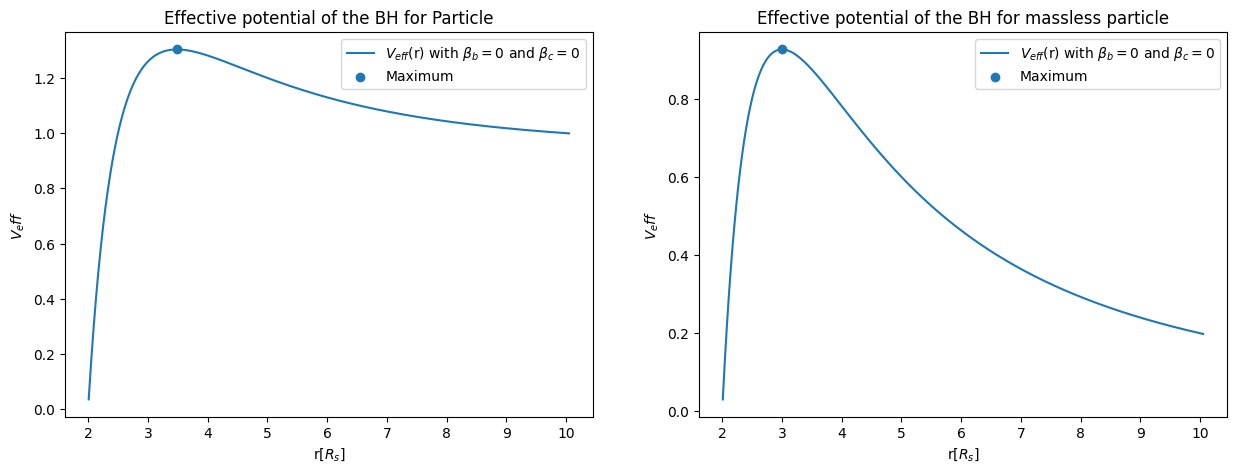

In [4]:
r_list = np.linspace(2 * M + 0.01, (2 * M + 0.01) * 5, 1000) 

min_particle, max_particle = BH.min_max_V_eff([2 * M + 0.01, (2 * M + 0.01) * 10],-1, L_0)
min, max = BH.min_max_V_eff([2 * M + 0.01, (2 * M + 0.01) * 10],0, L_0)

V_eff_list = BH.V_eff(r_list, 0, L_0)
V_eff_list_particle = BH.V_eff(r_list, -1, L_0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(r_list, V_eff_list_particle, label=fr'$V_{{eff}}$(r) with $\beta_b = 0$ and $\beta_c = 0$')  
ax1.scatter(max_particle, BH.V_eff(max_particle, -1, L_0),label='Maximum')

ax1.set_title('Effective potential of the BH for Particle') 
ax1.set_xlabel('r[$R_s$]')
ax1.set_ylabel('$V_eff$') 

ax1.legend()

ax2.plot(r_list, V_eff_list, label=fr'$V_{{eff}}$(r) with $\beta_b = 0$ and $\beta_c = 0$')  
ax2.scatter(max, BH.V_eff(max, 0, L_0),label='Maximum')

ax2.set_title('Effective potential of the BH for massless particle') 
ax2.set_xlabel('r[$R_s$]')
ax2.set_ylabel('$V_eff$') 

ax2.legend()
plt.show()

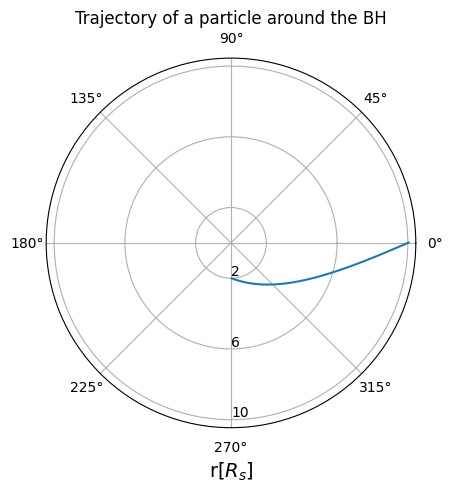

In [5]:
r_0_particle = 10

phi_list_particle = BH.phi(r_list, r_0_particle, sigma = -1, L = 15, E = -3)

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot data
ax.plot(phi_list_particle, r_list)

ax.set_rticks([2, 6, 10])
ax.set_rlabel_position(-90)  

ax.set_xlabel('r[$R_s$]', fontsize=14)
ax.set_title("Trajectory of a particle around the BH")

plt.show()

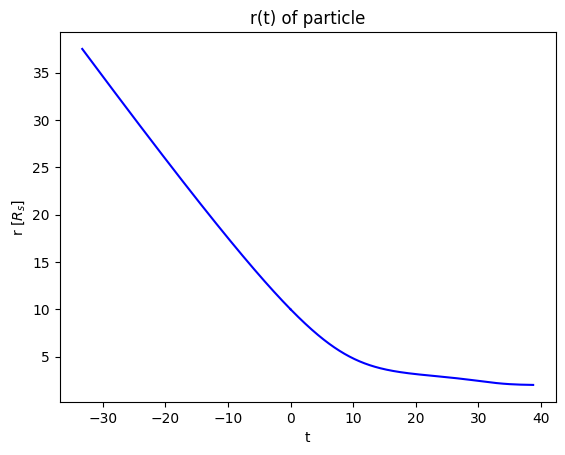

In [6]:
tau_span = [0, 10]
tau_list = np.linspace(tau_span[0], tau_span[1], 1000)

sp, sn, fall_In = BH.solve_DAE(tau_list, tau_span, sigma = -1, r_0=r_0_particle, L = 15, E = -3)

fig, ax = plt.subplots()

ax.plot(sp[0], sp[1], c= 'blue')  
ax.plot(sn[0], sn[1], c= 'blue')  

ax.set_title('r(t) of particle') 
ax.set_xlabel('t')
ax.set_ylabel('r [$R_s$]') 


plt.show()

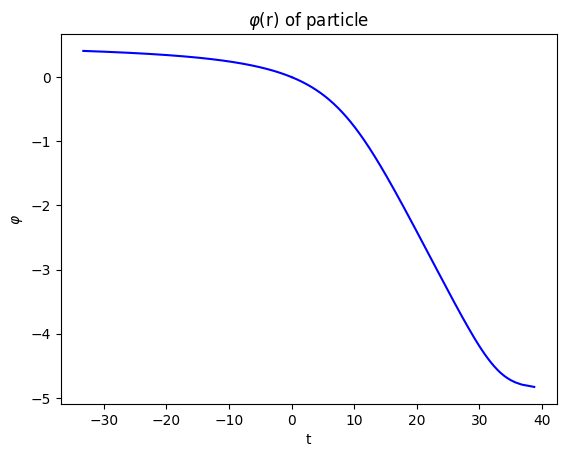

In [7]:
fig, ax = plt.subplots()

ax.plot(sp[0], sp[2], c= 'blue')  
ax.plot(sn[0], sn[2], c= 'blue')  

ax.set_title(rf'$\varphi$(r) of particle') 
ax.set_xlabel('t')
ax.set_ylabel(rf'$\varphi$') 

plt.show()

# 3: So what? (What does it mean?)
## Describe your results

All graphs look exactly as expected. Which means the code works so far so well and now can be used for the problems with unknown output.

Anirudh: - Elabroate on why its as expected. What does this plot you did define ?

# 4. Now what? (What's next?)
## Plan for the next week

Next, I will extend the draft code a bit by implementing more functions, like the perihel shift. I will also try to reduce everything to analytical solutions as much as possible and include OGRePY.

# Research Notebook
Lukas Lehmann (Student) <br>
Date: Jan. 27. - Feb. 03.

# 1: Experience
## Describe at least one research activity you worked on this week. 

### 1: Experience
As mentioned in 4, this week OGRePy was added and analytical solutions were introduced as far as possible

## Motivation:

The aim of this was to make the code more efficient and versatile.

# 2: What? (What happened?)
## Describe what happened during your activities for the week.

i have revised the draft file, the second version now looks like this:

In [10]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import solve_ivp
import numpy.lib.scimath as sm
from scipy.optimize import fminbound
from scipy.integrate import quad
import OGRePy as gr
import sympy as sp

from OGRePy.abc import t, phi, theta
r = gr.sym("r", nonnegative=True)

# Definition of spherical coordinates
Spherical = gr.Coordinates(t, r, theta, phi)

# Class definition for the Metric model
class MetricSystem:
    def __init__(self, f, g, h, param, M=1):
        """
        Initialize the  Metric model with given functions and parameters.

        Parameters:
        - f, g, h: Functions describing the system's behavior.
        - param: Parameters used by the functions f, g, and h.
        """
        # Store parameters and function definitions
        self.param = param
        self.safe_f = f
        self.safe_g = g
        self.safe_h = h

        # Create functions for f, g, h using provided parameters
        self.f = self.safe_f(r, param)
        self.g = self.safe_g(r, param)
        self.h = self.safe_h(r, param)

        self.M = param[0] # Mass of the black hole
        self.R_s = 2 * param[0]  # Schwarzschild radius

    def metric(self):
        """
        Define the black hole metric in spherical coordinates using the functions f, g, and h.

        Returns:
        - return_metric: A Metric object representing the black hole geometry.
        """
        # Create metric components
        return_metric = gr.Metric(
            coords=Spherical,
            components=gr.diag(-self.f, self.g, self.h, sp.sin(theta) ** 2 * self.h),
            symbol="eta",
        )
        return return_metric

    def __call__(self):
        return self.metric()

    def get_parameters(self, param):
        """
        Return the given parameters.

        Parameters:
        - param: Parameters to be returned.

        Returns:
        - param: The input parameters.
        """
        return param

    def set_parameters(self, param):
        """
        Set the parameters for the system, updating the function definitions.

        Parameters:
        - param: New set of parameters for the system.
        """
        self.param = param
        self.f = self.safe_f(r, param)
        self.g = self.safe_g(r, param)
        self.h = self.safe_h(r, param)

    def V_eff(self, r_val=None, sigma=0, L=1):
        """
        Compute the effective potential for a given radial coordinate 'r'.

        Parameters:
        - r_val: Radial coordinate.
        - sigma: Optional parameter, default is 0, -1 for particle.
        - L: Orbital angular momentum, default is 1.

        Returns:
        - V: Effective potential at the given r.
        """
        # Effective potential formula
        V = - self.f * (sigma - (L ** 2) / self.h)

        # Handle both symbolic and numerical inputs for r_val
        if isinstance(r_val, np.ndarray):
            V_num = sp.lambdify(r, V, "numpy")
            V_return = V_num(r_val)
        elif r_val is not None:
            V_return = V.subs(r, r_val)
        else:
            V_return = V

        return V_return

    def min_max_V_eff(self, sigma=0, L=1):
        """
        Find the minimum and maximum values of the effective potential V_eff
        within a given radial span.

        Parameters:
        - sigma: Optional parameter for the effective potential (default is 0).
        - L: Orbital angular momentum (default is 1).

        Returns:
        - min: The radial position r_min where the effective potential is minimized.
        - max: The radial position r_max where the effective potential is maximized.
        """
        V = self.V_eff(sigma=sigma, L=L)

        # Calculate the first and second derivatives of the effective potential
        dV_dr_1 = sp.diff(V, r)
        dV_dr_2 = sp.diff(dV_dr_1, r)

        # Solve for critical points (extremes)
        extrem = sp.solve(dV_dr_1, r)

        # Initialize lists to store minimum and maximum values
        min, max = [], []

        for i in range(len(extrem)):
            # Check if the second derivative is positive (min) or negative (max)
            if dV_dr_2.subs(r, extrem[i]) > 0:
                min.append(float(extrem[i]))
            elif dV_dr_2.subs(r, extrem[i]) < 0:
                max.append(float(extrem[i]))

        # Return both the minimum and maximum values
        return min, max

    def dphi_dr(self, r_val=None, sigma=0, L=1, E=1):
        """
        Calculate the derivative of the angle phi with respect to the radial distance r.

        Parameters:
        - r: The radial distance at which the derivative is evaluated.
        - sigma: Optional parameter for the effective potential (default is 0).
        - L: Orbital angular momentum (default is 1).
        - E: Energy (default is 1).

        Returns:
        - The derivative of phi with respect to r at the specified radial distance.
        """
        # Formula for the derivative of phi with respect to r
        dphi_dr_sym = (L / self.h) * sp.sqrt(self.f * self.g / (E**2 + self.V_eff(sigma=sigma, L=L)))

        # Handle both symbolic and numerical inputs for r_val
        if isinstance(r_val, np.ndarray):
            dphi_dr_num = sp.lambdify(r, dphi_dr_sym, "numpy")
            dphi_dr_return = dphi_dr_num(r_val)
        elif r_val is not None:
            dphi_dr_return = dphi_dr_sym.subs(r, r_val)
        else:
            dphi_dr_return = sp.simplify(dphi_dr_sym)

        return dphi_dr_return

    def phi(self, r_val, r_span, phi_0=0, sigma=0, L=1, E=1):
        """
        Calculate the angle phi for a list of radial distances r_list by integrating the derivative dphi/dr.

        Parameters:
        - r_list: A list or array of radial distances where phi is to be evaluated.
        - phi_0: The reference radial position (default is 0), where phi(r0) is set to 0.
        - sigma: Optional parameter for the effective potential (default is 0).
        - L: Orbital angular momentum (default is 1).
        - E: Energy (default is 1).

        Returns:
        - An array of phi values corresponding to each radial distance in r_list.
        """
        # Getting the derivative dphi/dr
        d_phi_dr = self.dphi_dr(r_val=None, sigma=sigma, L=L, E=E)

        # Perform symbolic integration
        phi = sp.integrate(d_phi_dr, r)

        if sp.Integral(d_phi_dr, r) == phi:
            # Lambdify the derivative to be used in the solver
            d_phi_dr_func = sp.lambdify(r, d_phi_dr, "numpy")

            # Define the ODE system for numerical integration
            def ode_system(r, phi):
                return d_phi_dr_func(r)

            # Use scipy's solve_ivp to numerically integrate dphi/dr
            phi_list = solve_ivp(ode_system, r_span, [phi_0], t_eval=r_val, method='RK45')
            phi_return = phi_list.y[0]
        else:
            # Return the symbolic result if no numerical integration is needed
            phi_return = phi

        return phi_return 

    def solve_DAE(self, tau, tau_span, r_0, t_0=0, phi_0=0, sigma=0, L=1, E=1):
        """
        Solve the system of differential-algebraic equations (DAE) for motion around the black hole.

        Parameters:
        - tau: Time parameter (proper time) for the solution.
        - tau_span: The span of tau for integration.
        - r_0: Initial radial position.
        - t_0: Initial time (default is 0).
        - phi_0: Initial angle (default is 0).
        - sigma: Optional parameter for the effective potential (default is 0).
        - L: Orbital angular momentum (default is 1).
        - E: Energy (default is 1).
        - R_s: Schwarzschild radius (default is 2).

        Returns:
        - result_p: Solution for the forward direction.
        - result_n: Solution for the reverse direction.
        - Falls_in: Boolean flag indicating if the object falls into the black hole.
        """
        # Lambdify the functions f, g, and h for symbolic expressions
        f = sp.lambdify(r, self.f, "numpy")
        g = sp.lambdify(r, self.g, "numpy")
        h = sp.lambdify(r, self.h, "numpy")

        # Define the system of differential equations for the DAE
        def DAE(tau, y, delta):
            t, r, phi = y

            # Differential equations for t, r, and phi
            dtdtau = delta * E / f(r)
            dphidtau = delta * L / h(r)
            argument = 1 / g(r) * ((E ** 2) / f(r) + sigma - (L ** 2) / h(r))

            # Radial motion (using sqrt of the argument)
            if argument >= 0:
                drdtau = delta * np.sqrt(argument)
            else:
                print(f"Warning: E < V_eff at r = {r}")
                drdtau = delta * np.sqrt(argument.real)

            return [dtdtau, drdtau, dphidtau]

        # Initial conditions for the differential equations
        initial_conditions = [t_0, r_0, phi_0]

        # Solve the differential equations for both directions (forward and reverse)
        sol_p = solve_ivp(DAE, tau_span, initial_conditions, t_eval=tau, args=[1], method='RK45')
        sol_n = solve_ivp(DAE, tau_span, initial_conditions, t_eval=tau, args=[-1], method='RK45')

        Falls_in = False

        # Function to check if the solution falls inside the event horizon
        def Falls_in_BH(arr):
            index = np.where(arr.y[1] < self.R_s)[0]
            if index.size > 0:
                Falls_in = True
                result = arr.y[:, :index[0]]  # Return solution up to event horizon
            else:
                result = arr.y[:]  # Return full solution

            return result

        # Get results for both directions
        result_p = Falls_in_BH(sol_p)
        result_n = Falls_in_BH(sol_n)

        return result_p, result_n, Falls_in

# Class for the Black Hole
class BH:
    def __init__(self, M, Metric_sys_list, Metric_Name_list):
        self.M = M
        self.R_s = 2 * M  # Schwarzschild radius (R_s)

        # Lists to store MetricSystem instances and their corresponding names
        self.Metric_sys_list = Metric_sys_list
        self.Metric_Name_list = Metric_Name_list

        # Add MetricSystem instances dynamically based on the provided names
        for Metric_sys, Metric_Name in zip(self.Metric_sys_list, self.Metric_Name_list):
            self.add_Metric_sys(Metric_sys, Metric_Name)

    def add_Metric_sys(self, Metric_sys, Metric_Name):
        """Dynamically adds a new MetricSystem instance to the BH object."""
        # Dynamically set the attribute with the given name
        Metric_sys.set_parameters([self.M, Metric_sys.set_parameters[1:]])
        setattr(self, Metric_Name, Metric_sys)
      


# 3: So what? (What does it mean?)
## Describe your results

The code now has additional possibilities, this has also been summarised in a documentation (see our GitHub). Most functions can now also be displayed symbolically.

# 4. Now what? (What's next?)
## Plan for the next week

revision of the phi dunction of the draft document and introduction of an improved metric.

NO reference ?


| Category       | Points      |
| ------------- |:------------:|
| Formatting    |       1       |
| Experience    |       2       |
| What?         |       2       |
| So what?      |       3       |
| Now what?     |       4       |
| Bibliography  |       0       |
| Style         |       1       |
| Total         |       13      |

I think there is formating issues with this file, the things are repeatedly pasted. 

There are few comments, these journals require you to explain in text on your research goal , gap and the things you did during this week. You dont have to copy paste the entire code and then show the plot. The plots and explanation is more than enough. 
